# Классичесское машинное обучение

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xg
import lightgbm as lgb

In [139]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import classification_report
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

## Загрузка и предобработка данных

Дана таблица bank_clients_data.csv, содержащая данные о клиентах банка.<br>Необходимо решить задачу классификации, покинул клиент банк или нет. <br>
Поля таблицы:

* RowNumber — соответствует номеру записи (строки)
* СustomerId — id клиента;
* Surname — фамилия клиента;
* CreditScore — кредитный рейтиинг клиента, полученный в результате каких-то расчетов внутри банка;
* Geography — местоположение клиента;
* Gender — пол;
* Age — возраст;
* Tenure — количество лет, в течение которых человек является клиентом банка;
* Balance — остаток на счете;
* NumOfProducts — количество продуктов, которые клиент приобрел через банк;
* HasCrCard — есть ли у клиента кредитная карта. 1-да, 0-нет;
* IsActiveMember — активный-1 или нет-2 клиент;
* EstimatedSalary — заработная плата;
* Exited — перестал ли клиент пользоваться услугами банка и в принципе быть его клиентом. Целевая переменная. Характеризует отток.


## 1. EDA. Общее представление о данных

#### 1. Выведем информацию о каждом столбце (среднее значение, среднее отклонение, основные процентили итп)

In [3]:
data = pd.read_csv('bank_clients_data.csv', index_col = False)
print(data.drop(columns=['RowNumber','CustomerId']).describe(include='all'))

       Surname   CreditScore Geography Gender           Age        Tenure  \
count    10000  10000.000000     10000  10000  10000.000000  10000.000000   
unique    2932           NaN         3      2           NaN           NaN   
top      Smith           NaN    France   Male           NaN           NaN   
freq        32           NaN      5014   5457           NaN           NaN   
mean       NaN    650.528800       NaN    NaN     38.921800      5.012800   
std        NaN     96.653299       NaN    NaN     10.487806      2.892174   
min        NaN    350.000000       NaN    NaN     18.000000      0.000000   
25%        NaN    584.000000       NaN    NaN     32.000000      3.000000   
50%        NaN    652.000000       NaN    NaN     37.000000      5.000000   
75%        NaN    718.000000       NaN    NaN     44.000000      7.000000   
max        NaN    850.000000       NaN    NaN     92.000000     10.000000   

              Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count 

#### 2. 80% процентиль по полю зарплаты.

In [5]:
print(f'80% процентиль по полю зарплаты: {data['EstimatedSalary'].quantile(0.8).round(1)}')

80% процентиль по полю зарплаты: 159836.7


Данное значение по полю зарплаты говорит о том, что 80% клиентов банка получают не больше данной суммы. Если сравнить его с другими проценталями, то можно заметить, что клиентами банка являются люди с разными уровнями дохода. При этом, если посмотреть на верхние 20%, то видно, что в него также попадают люди с разным уровнем дохода.

#### 3. Есть ли в данных пропущенные значения?

In [6]:
data.isna().any().any()

False

В данных нет пропущенных значений.

#### 4. Проверим сбалансированность классов и сделаем вывод 


In [7]:
data['Exited'].value_counts(normalize=True)

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

Присутствует явный дисбаланс классов, что говорит о том, что при обучении это нужно будет учитывать, а также использовать соответствующие метрики качества.

## 2. Построение графиков 

#### 1. Построим гистограмму распределения возраста клиентов.

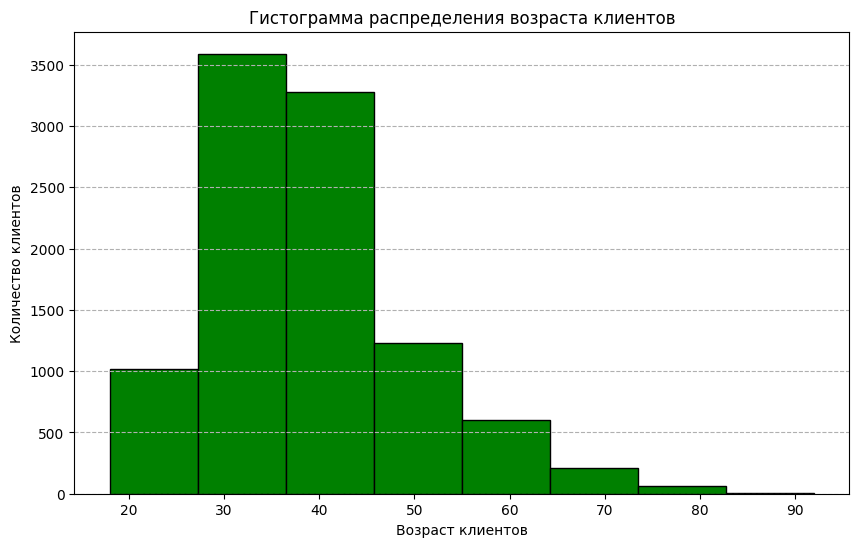

In [36]:
plt.figure(figsize=(10, 6))
plt.hist(data['Age'],
         bins=8,
         color='green',
         edgecolor='black')
plt.title('Гистограмма распределения возраста клиентов')
plt.xlabel('Возраст клиентов')
plt.ylabel('Количество клиентов')
plt.grid(axis='y', linestyle='--')
plt.show()

#### 2. Построим график распределения количества ушедших клиентов исходя из их пола. Наверху каждого столбца отобразим количественный показатель.

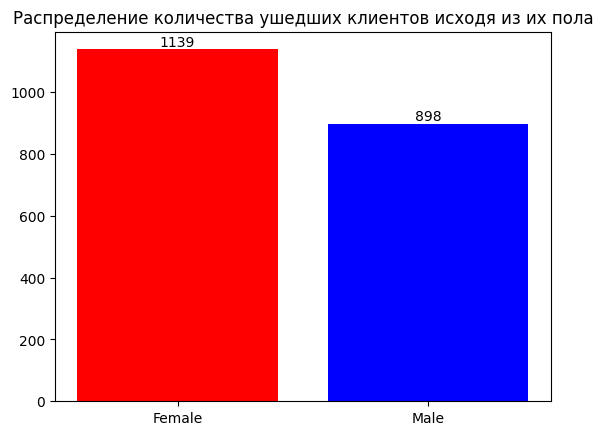

In [45]:
target_gender = data[data['Exited'] == 1]['Gender'].value_counts()

#plt.figure(figsize=(10, 6))
bars = plt.bar(target_gender.index, target_gender.values, color=['red','blue'])
plt.bar_label(bars)
plt.title('Распределение количества ушедших клиентов исходя из их пола')
plt.show()

Вывод: Женщины чаще перестают быть клиентами банка , однако их доля от общего числа уходов составляет около 56%, т.е. разница с мужчинами небольшая. Возможно, если взять выборку большего размера, то их доля приблизится к 50%.

#### 3. Возьмем данные о географии клиентов и их доходах. Построим круговую диаграмму, отображающую картину среднего заработка по странам (должны быть видны страны и конкретные числовые значения)

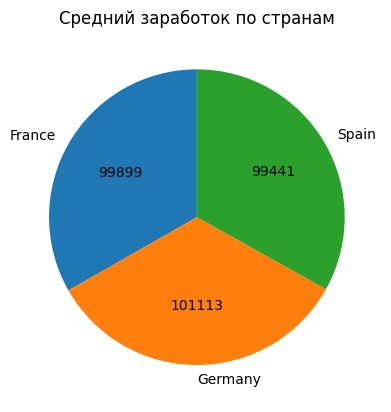

In [62]:
grpby_country = data.groupby('Geography')['EstimatedSalary'].mean()
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{val}'
    return my_autopct
plt.pie(grpby_country.values, 
        autopct=make_autopct(grpby_country.values), 
        labels=grpby_country.index, 
        startangle=90)
plt.title('Средний заработок по странам')
plt.show()

#### 4. Построим тепловую карту корреляции всех признаков из таблицы. Согласно полученной карте, какие признаки показывают наибольшую взаимосвязь? 

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


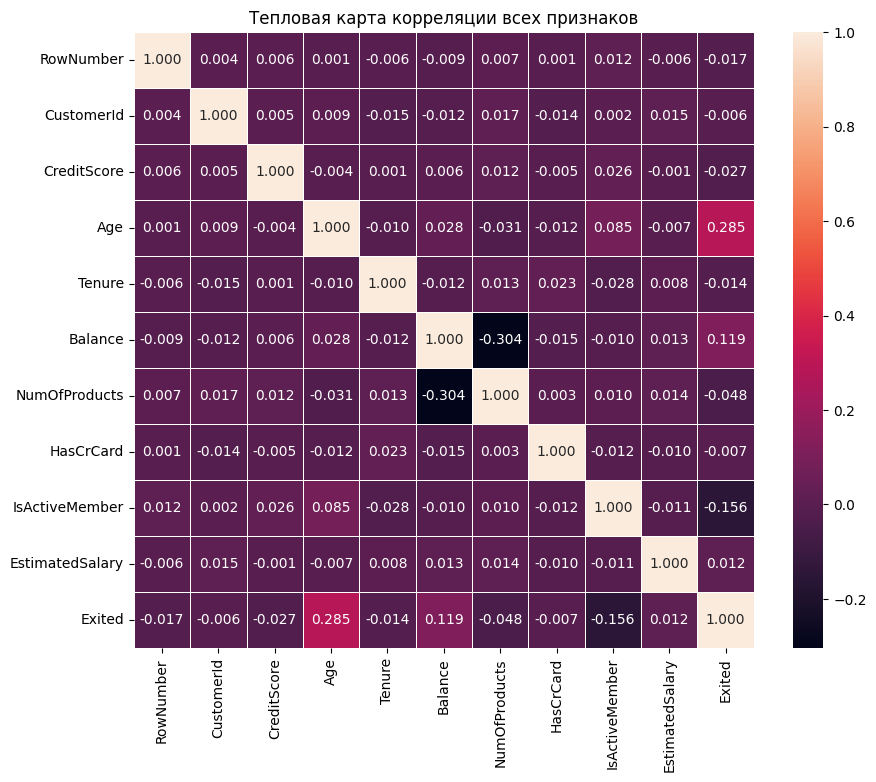

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.drop(columns=['Surname','Geography','Gender']).corr(),
            annot=True,
            fmt=".3f",
            linewidths=0.5)
plt.title('Тепловая карта корреляции всех признаков')
plt.show()

Поскольку посчитать корреляцию можно только между числовыми признаками, а категориальные мы еще не кодировали, то тепловая карта строится без них. Наибольшую зависимость показывают признаки: Exited и Age, Exited и IsActiveMember, Balance и NumOfProducts.

## 3. Подготовка данных к использованию в алгоритмах ml

####  1. Избавимся от полей, которые являются неинформативными.

In [19]:
data['CustomerId'].nunique()

10000

In [20]:
data['RowNumber'].nunique()

10000

In [21]:
clear_data = data.drop(columns=['RowNumber','CustomerId'])

Столбцы RowNumber и CustomerId несут схожую информацию. При этом в этой информации нет необходимости, поскольку каждая запись в таблице несет информацию об уникальном клиенте. 

#### 2. Переведем категориальные данные в числовые. 

In [22]:
def encod(ohe_list, le_list):
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    enc = encoder.fit_transform(clear_data[ohe_list])
    enc_data =pd.DataFrame(enc, columns=encoder.get_feature_names_out(ohe_list))
    data_enc = pd.concat([clear_data, enc_data], axis=1)
    data_enc = data_enc.drop(ohe_list,axis=1)

    LE_encoder = LabelEncoder()
    for col in le_list:
        data_enc[col] = LE_encoder.fit_transform(data_enc[col])
    return data_enc

In [23]:
obj_LE = ['Surname','Geography']
obj_OHE = ['Gender']
res_data = encod(obj_OHE, obj_LE)

Использовалось два метода кодирования - One-Hot энкодер и Label энкодер. Поскольку у признака Surname большое количество уникальных значений, его необходимо кодировать Label энкодером.

#### 3. Разделим данные на train (80%) и test (20%)

1. Для задачи линейной регрессии, целевой признак Age<br>
X_reg_train, X_reg_test, y_reg_train, y_reg_test

2. Для задачи логистической регрессии. Целевой признак Exited<br>
X_cl_train, X_cl_test, y_cl_train, y_cl_test

In [25]:
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(res_data.drop(columns='Age'), res_data['Age'], test_size=0.2)
X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(res_data.drop(columns='Exited'), res_data['Exited'], test_size=0.2)

#### 4. Стандартизируем данные для классификации или регресии.

In [30]:
scaler = StandardScaler()

scaler.fit(X_reg_train)
X_reg_train = scaler.transform(X_reg_train)
X_reg_test = scaler.transform(X_reg_test)

In [31]:
scaler.fit(X_cl_train)
X_cl_train = scaler.transform(X_cl_train)
X_cl_test = scaler.transform(X_cl_test)

Поскольку у некоторых признаков очень разные масштабы (разница в несколько порядков), лучше стандартизировать.

## 4. Работа с ml моделями

#### 1. Реализуем модель линейной регрессии для поля 'Age' аналитическим способом, используя формулу весов, полученную от минимизации ошибок по методу наименьших квадратов. 

$ w = (X^TX)^{-1}X^TY $

In [ ]:
# Функция, которая принимает значения выборок, полученных выше (X_reg_train, X_reg_test, y_reg_train, y_reg_test) и 
# выдаёт среднюю абсолютную ошибку и корень из среднеквадратичной ошибки по тестовой выборке

def lin_reg_1 (X_tr, y_tr, X_te, y_te):
    X_tr = np.hstack([X_tr, np.ones((X_tr.shape[0], 1))])
    X_te = np.hstack([X_te, np.ones((X_te.shape[0], 1))])

    weights = np.linalg.inv(X_tr.T @ X_tr) @ X_tr.T @ y_tr
    y_pr = X_te @ weights
    
    mae = mean_absolute_error(y_te, y_pr)
    rmse = root_mean_squared_error(y_te, y_pr)
    return mae, rmse

In [53]:
mae, rmse = lin_reg_1(X_reg_train, y_reg_train,X_reg_test,y_reg_test)
print(f'MAE = {mae}; RMSE = {rmse}')

MAE = 7.182515055434045; RMSE = 9.639121825405319


Дополнительный столбец из 1 необходим для того, чтобы функция приближения имела свободный член.

#### 2. Реализуем модель линейной регрессии при помощи любого готового пакета, сравним полученное mae из двух моделей, из этого решения и полученного выше. 

In [56]:
lin_reg = LinearRegression()
lin_reg.fit(X_reg_train, y_reg_train)
y_pred = lin_reg.predict(X_reg_test)

mae_pack = mean_absolute_error(y_reg_test, lin_reg.predict(X_reg_test))

print(f'MAE аналитическое = {mae}; MAE из пакета = {mae_pack}')
print(f'Разница = {abs(mae-mae_pack)}')

MAE аналитическое = 7.182515055434045; MAE из пакета = 7.182515055434002
Разница = 4.3520742565306136e-14


Вывод: аналитическое решение получилось очень схожим по качеству с пакетным, что может говорить о том, что в sklearn также используется аналитическое решение.

#### 3. Реализуем модель логистической регрессии для поля 'Exited'

1. Напишим функцию активации, которую в дальнейшем будем использовать. <br>
$y_{pred}(y') = \frac{1}{1 + e^{-\langle y' \rangle}}
$

In [ ]:
def sigmoid(z):
    y_pred = 1/(1 + np.exp(-z))
    return y_pred

2. Напишем функцию кроссэнтропии<br>
$L(w) = -y\, log\,y_{pred} - (1-y)\,log\,(1-y_{pred})$

In [ ]:
def ce(y,y_pr):
    loss = -y * np.log(sigmoid(y_pr)) - (1 - y) * np.log(1 - sigmoid(y_pr))

3. Дополним архитектуру логистической регрессии. Обучим и предскажем результаты по тестовой выборки раннее полученнх данных для классификации. (X_cl_train, X_cl_test, y_cl_train, y_cl_test). <br>
Цель: Получить weighted avg >= 0.68 по каждой метрике из отчёта

In [ ]:
class Hand_made_Logistic_reg:
    
    def sigmoid(self, h):
        y_pred = 1/(1 + np.exp(-h))
        return y_pred


    def loss_function(self, X, y, weights): 
        y_hat = np.dot(X, weights)

        return sum(-y * np.log(self.sigmoid(y_hat)) - (1 - y) * np.log(1 - self.sigmoid(y_hat)))  /len(X)

    
    def fit(self, X, y, epochs= 100, lr= 0.05):      
        loss = []
        X = np.hstack([X, np.ones((X.shape[0], 1))])
        weights = np.random.rand(X.shape[1])
        N = X.shape[0] #кол-во cтрочек в датасете 
                 
        for epoch in range(epochs):        
            # Градиентный спуск:
            y_hat = self.sigmoid(np.dot(X, weights))

            #Функция обновления весов 
            weights -= lr*(np.dot(X.T,(y_hat - y))/N)

            loss.append(self.loss_function(X,y,weights))
            #Отображение ошибок по эпохам во время обучения
            print('Эпоха:', epoch, 'Loss:', loss[-1])
        self.weights = weights
        self.loss = loss
     
    
    def predict(self, X):        
        # скалярное умножение весов и новых значений х
        X = np.hstack([X, np.ones((X.shape[0], 1))])
        y_hat = self.sigmoid(np.dot(X, self.weights))
        # возвращение списка значений, которые выше определенного уровня вероятности
        return np.where(y_hat > 0.5, 1, 0)

In [ ]:
# Сlassification_report
log_reg = Hand_made_Logistic_reg()
log_reg.fit(X_cl_train, y_cl_train)

Эпоха: 0 Loss: 1.1804682190978515
Эпоха: 1 Loss: 1.1683938665273697
Эпоха: 2 Loss: 1.1564521087181203
Эпоха: 3 Loss: 1.144643218172772
Эпоха: 4 Loss: 1.132967436808996
Эпоха: 5 Loss: 1.1214249752613634
Эпоха: 6 Loss: 1.1100160122108824
Эпоха: 7 Loss: 1.0987406937443946
Эпоха: 8 Loss: 1.0875991327460337
Эпоха: 9 Loss: 1.0765914083229058
Эпоха: 10 Loss: 1.0657175652670983
Эпоха: 11 Loss: 1.054977613556075
Эпоха: 12 Loss: 1.0443715278934307
Эпоха: 13 Loss: 1.0338992472919115
Эпоха: 14 Loss: 1.023560674700498
Эпоха: 15 Loss: 1.0133556766772636
Эпоха: 16 Loss: 1.0032840831095913
Эпоха: 17 Loss: 0.9933456869832158
Эпоха: 18 Loss: 0.9835402442014248
Эпоха: 19 Loss: 0.9738674734556089
Эпоха: 20 Loss: 0.9643270561481977
Эпоха: 21 Loss: 0.9549186363688641
Эпоха: 22 Loss: 0.9456418209247107
Эпоха: 23 Loss: 0.9364961794249801
Эпоха: 24 Loss: 0.9274812444206564
Эпоха: 25 Loss: 0.9185965115991394
Эпоха: 26 Loss: 0.9098414400339945
Эпоха: 27 Loss: 0.9012154524895878
Эпоха: 28 Loss: 0.8927179357802337

In [136]:
y_pred_cl = log_reg.predict(X_cl_test)
CR = classification_report(y_cl_test,y_pred_cl)
print(CR)

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1606
           1       0.33      0.36      0.34       394

    accuracy                           0.73      2000
   macro avg       0.58      0.59      0.59      2000
weighted avg       0.74      0.73      0.73      2000



#### 4. Создадим стэк из 3-х моделей, одна из которых должна быть на оcнове бустинга деревьев, другая использоваться в комплексе с жадным подбором гиперпараметров.

In [ ]:
xgb = xg.XGBClassifier()
lgboost = lgb.LGBMClassifier()

knn = KNeighborsClassifier()
param = {'n_neighbors': range(1, 30)}
grid_search = GridSearchCV(estimator=knn,
                           param_grid=param,
                           cv=3)
grid_search.fit(X_cl_train,y_cl_train)
knn_grs = grid_search.best_estimator_

In [ ]:
meta_model = LogisticRegression()

estimators = [
    ('knn', knn_grs),
    ('XGb', xgb),
    ('lgbm', lgboost)
]
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model
)
stack.fit(X_cl_train,y_cl_train)

[LightGBM] [Info] Number of positive: 1643, number of negative: 6357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,001450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,205375 -> initscore=-1,353033
[LightGBM] [Info] Start training from score -1,353033
[LightGBM] [Info] Number of positive: 1315, number of negative: 5085
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1116
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,205469 -> initscore=-1,352458
[LightGBM] [Info] Start training from score -1,352458
[LightGBM] [Info] 

StackingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=11)),
                               ('XGb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_polic...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('lgbm', LGBMClassifier())],
                   final_estimator=LogisticRegression())

In [170]:
y_pred_cl_st = stack.predict(X_cl_test)
CR_st = classification_report(y_cl_test,y_pred_cl_st)
print(CR_st)

              precision    recall  f1-score   support

           0       0.89      0.96      0.93      1606
           1       0.77      0.52      0.62       394

    accuracy                           0.88      2000
   macro avg       0.83      0.74      0.77      2000
weighted avg       0.87      0.88      0.87      2000



В качестве базовых моделей использовались два алгоритма градиентного бустинга, а также KNN с подбором количества соседей. В качестве метамодели используется логистическая регрессия.